In [134]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth=100

In [135]:
def jaccard_similarity(str1, str2):
    string_set1 = set(str1.split(' '))
    string_set2 = set(str2.split(' '))
    return len(string_set1.intersection(string_set2))/len(string_set2.union(string_set1))

In [136]:
# dump pkl into a pandas dataframe. 
data = pd.read_pickle('data/string_study.pkl')

In [137]:
# data.head()

In [138]:
data["word_count"] = data._info.apply(lambda x:len(x.split(' ')))

In [139]:
# data.head()

In [140]:
class_by_len = set(data["word_count"])

In [141]:
# class_by_len

In [142]:
bin_len = len(class_by_len)
bin_len

45

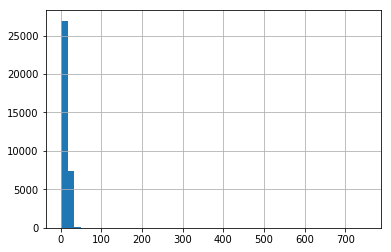

In [143]:
# Analysis of messages categorized into words
data.word_count.hist(bins = bin_len)

In [144]:
# Find the class with highest freq. 
dict = {}
for item in class_by_len:
    temp_frame = np.array(data.query("word_count == @item"))
    dict[str(item)] = len(temp_frame)

In [145]:
check_regex_msg = np.array(filtered_data.msg.copy())
set(check_regex_msg)

{"Server raised fault: \\'API#Device SERVER-E9656C94-7C97-4CC2-B949-38D0056C5D15 is currently BLOCKED a",
 'Unable to connect to LanDB\\nTraceback (most recent call last):\\n\\n  File "/usr/lib/python2.7/site-pa'}

In [146]:
# The word_count with the highest frquncy is "9"
filtered_data = data.query("word_count == 37")
# filtered_data.head(47)

In [147]:
msg_array = np.array(filtered_data._info.copy())
msg_array

array(['Resource <Server: rally-f598-ZkDr> has ERROR status.  Fault: {u\'message\': u\'Server raised fault: \\\'API#Device SERVER-E9656C94-7C97-4CC2-B949-38D0056C5D15 is currently BLOCKED and can not be updated.\\n\\\'\\nTraceback (most recent call last):\\n\\n  File "/usr/lib/python2.7/site-packages/oslo_messaging/rpc/server.py", line 155, in _process_i\', u\'code\': 500, u\'created\': u\'2018-04-18T16:04:47Z\'}',
       'Resource <Server: rally-3a2c-rWlq> has ERROR status. Fault: {u\'message\': u\'Unable to connect to LanDB\\nTraceback (most recent call last):\\n\\n  File "/usr/lib/python2.7/site-packages/oslo_messaging/rpc/server.py", line 155, in _process_incoming\\n    res = self.dispatcher.dispatch(message)\\n\\n  File "/usr/lib/python2.7/site-packages/osl\', u\'code\': 500, u\'created\': u\'2018-04-10T21:53:13Z\'}'],
      dtype=object)

In [148]:
msg_array = np.array(filtered_data._info.copy())
jaccard_sim_set = []
jaccard_matrix = [[0 for i in range(len(msg_array))] for j in range(len(msg_array))]
for i in range(0, len(msg_array)):
    jaccard_matrix[i][i] = 1
    for j in range(i+1, len(msg_array)):
        jaccard_sim = jaccard_similarity(msg_array[i], msg_array[j])
        jaccard_sim_set.append(jaccard_sim)
        jaccard_matrix[i][j] = jaccard_sim
        jaccard_matrix[j][i] = jaccard_sim

In [149]:

# Number of classes according to the Regex split
len(set(np.array(filtered_data.msg)))

2

In [150]:
len(set(jaccard_sim_set))
bin_len_jacc = len(set(jaccard_sim_set))
bin_len_jacc

1

In [151]:
# Optimum thresold value to produce the numberof classes same as in that of the labelled data 
opti_thres = sum((jaccard_sim_set))/len((jaccard_sim_set))
# Check all the values in the jaccard similarities set
jaccard_sim_set

[0.425531914893617]

In [152]:
jaccard_dataframe = pd.DataFrame(jaccard_sim_set)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126c46e10>]],
      dtype=object)

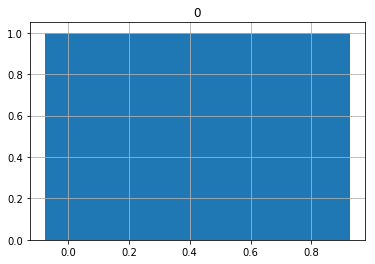

In [153]:
jaccard_dataframe.hist(bins = bin_len_jacc)

In [154]:
# jaccard_matrix[-1][-3] 

#      Minhashing starts here


In [155]:
# Shingle generators 
# Arguments : Message string, shingle size {in words}
# Returns : All shingles formed with k words
def shingle_generator(message, k):
    message = message.split(' ')
    item_set = []
    for i in range(0, len(message)-k):
        shingle =  ""
        for j in range(0, k):
            shingle = shingle + message[i+j] + " "
        item_set.append(shingle)
    return item_set

In [156]:
raw_msgs = filtered_data._info

In [157]:
# Generate the set of words of all raw messages
message_set = []
# %time

for item in np.array(raw_msgs):
#     print(item)
    item = str(item)
    set_of_words = set(item.split(' '))
    # Shingle size is set to 3 words
    set_of_words = set(shingle_generator(item, 2))
    message_set.append(set_of_words)

In [158]:
import numpy as np
import csv
import pandas
from datasketch import MinHash, MinHashLSH

In [159]:
# Generate MinHash instances for all messages
m = []
for i in range (0, len(message_set)):
    m_temp = MinHash(num_perm=128)
    m.append(m_temp)
len(m)

2

In [160]:
i = 0
for message in message_set:
    for word in message:
        m[i].update(word.encode('utf-8'))
    i = i + 1

# Create an LSH indexb
# %time
lsh = MinHashLSH(threshold=.2, num_perm=128)
count = 0
for i in range (0, len(m)):
    string = "m" + str(i)
    lsh.insert(string, m[i])
    count += 1

In [161]:
# Find all the messages similar to the fist message with a specified threshold
result = lsh.query(m[0])
# (result)

In [162]:
# Repeat the clustering proc for every message. 
clusters = {}
cluster_count = 1
# For every message add the result to the cluster
for i in range(0, len(m)):
    # check if the message belongs to any cluster
    msg_str = "m" + str(i)
    flag = 1
    for item in clusters.values():
        if msg_str in item:
            flag = 0
            break
    # End of check box
    if flag:
        result = lsh.query(m[i])
        clusters[cluster_count] = result
        cluster_count += 1

In [163]:
clusters

{1: ['m1', 'm0']}